
# Autoencoder Pretraining with CNN Classifier (TensorFlow Tutorial)

Workflow:
1. Pretrain Autoencoder (Encoder + Decoder)
2. Save Encoder Weights
3. Load Encoder Weights into TensorFlow CNN Classifier Tutorial Model
4. Train Classifier on Labeled Data


In [ ]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/content/drive')
# One-time copy from Drive to local
!cp -r "/content/drive/MyDrive/PaddedImages_2/train" "/content/train"
!cp -r "/content/drive/MyDrive/PaddedImages_2/test" "/content/test"

Mounted at /content/drive


In [ ]:
# Data loading
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/train'
test_dir = '/content/test'

# # Set up the ImageDataGenerator for data augmentation and normalization
# train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale image pixel values to [0, 1]
# test_datagen = ImageDataGenerator(rescale=1./255)

# # Load training data
# train_generator = train_datagen.flow_from_directory(
#     train_dir,  # Path to training data
#     target_size=(224, 224),  # Resize images to match the input size
#     batch_size=32,
#     class_mode='sparse'  # For integer labels (use 'categorical' for one-hot encoded)
# )
# print("Class indices:", train_generator.class_indices)

# # Load testing data
# test_generator = test_datagen.flow_from_directory(
#     test_dir,  # Path to testing data
#     target_size=(224, 224),  # Resize images to match the input size
#     batch_size=32,
#     class_mode='sparse'  # For integer labels (use 'categorical' for one-hot encoded)
# )

# Setup for both training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

N_batch = 200  # batch size

# Base generators (no labels)
base_train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # No labels
    shuffle=True
)

base_val_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=N_batch,
    class_mode=None,
    shuffle=False
)

# Generator wrapper: returns (x, x) for autoencoder
def autoencoder_generator(generator):
    for batch in generator:
        yield batch, batch

# Final generators
train_generator = autoencoder_generator(base_train_gen)
test_generator = autoencoder_generator(base_val_gen)


Found 23667 images belonging to 2 classes.
Found 6750 images belonging to 2 classes.


In [2]:
from tensorflow import keras
code_size = 32  # size of autoencoder codes
hid_size = 128 # number of hidden units in network layers
N_batch = 200  # batch size

def build_encoder():
    encoder = keras.models.Sequential([
        keras.layers.Input(shape=(224, 224, 3)),  # input shape
        keras.layers.Conv2D(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 112x112
        keras.layers.Conv2D(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 56x56
        keras.layers.Conv2D(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 28x28
        keras.layers.Conv2D(code_size, kernel_size=4, strides=2, activation=None, padding='same'),   # 14x14
    ])

    return encoder


def build_decoder():
    decoder = keras.models.Sequential([
        keras.layers.Conv2DTranspose(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 28x28
        keras.layers.Conv2DTranspose(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 56x56
        keras.layers.Conv2DTranspose(hid_size, kernel_size=4, strides=2, activation='relu', padding='same'),  # 112x112
        keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, activation='sigmoid', padding='same'),      # 224x224x3
    ])
    return decoder

In [ ]:

# from tensorflow import keras
# from tensorflow.keras import layers, models

# (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
save_dir = '/content/drive/MyDrive/COMP562/autoencoder_weights'


encode_nnet = build_encoder()
# encode_nnet.build([N_batch, 224, 224, 1])

decode_nnet = build_decoder()
# decode_nnet.build(encode_nnet.output_shape)

autoencoder = keras.models.Sequential([
    encode_nnet,
    decode_nnet
])


autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(x_train, x_train, epochs=5, batch_size=64, validation_split=0.1)
history = autoencoder.fit(
    train_generator,
    steps_per_epoch=base_train_gen.samples // base_train_gen.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=base_val_gen.samples // base_val_gen.batch_size
)

# Save encoder weights
import os
encode_nnet.save_weights(os.path.join(save_dir, 'encoder_cnn_besttt.weights.h5'))


Epoch 1/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 329s 430ms/step - loss: 0.0330 - val_loss: 0.0021
Epoch 2/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 284s 375ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 3/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 337s 457ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 321s 435ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 5/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 332s 449ms/step - loss: 0.0171 - val_loss: 0.0021
Epoch 6/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 332s 450ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 332s 449ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 320s 434ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 326s 442ms/step - loss: 0.0012 - val_loss: 9.9566e-04
Epoch 10/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 311s 422ms/step - loss: 0.0027 - val_loss: 0.0011


In [ ]:
decode_nnet.save_weights(os.path.join(save_dir, 'decoder_cnn_besttt.weights.h5'))


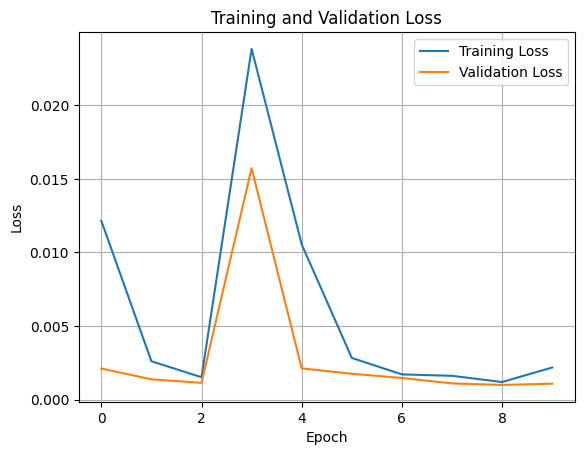

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

From Here Starts CNN

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/COMP562/autoencoder_weights'
encode_nnet = build_encoder()
encode_nnet.load_weights(os.path.join(save_dir, 'encoder_cnn_besttt.weights.h5'))
encode_nnet.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        65,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,384 (2.28 MB)

 Trainable params: 596,384 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Load Dataset Train/Test for CNN classifier

In [4]:
# One-time copy from Drive to local
!cp -r "/content/drive/MyDrive/PaddedImages_2/train" "/content/train"
!cp -r "/content/drive/MyDrive/PaddedImages_2/test" "/content/test"

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/train'
test_dir = '/content/test'

# Set up the ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale image pixel values to [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to training data
    target_size=(224, 224),  # Resize images to match the input size
    batch_size=32,
    class_mode='sparse'  # For integer labels (use 'categorical' for one-hot encoded)
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to testing data
    target_size=(224, 224),  # Resize images to match the input size
    batch_size=32,
    class_mode='sparse'  # For integer labels (use 'categorical' for one-hot encoded)
)

Found 23667 images belonging to 2 classes.
Found 6750 images belonging to 2 classes.


Train CNN with Autoencoder (saved Encoder weights)

In [11]:
batch = next(test_generator)
print(type(batch))        # should be a tuple
print(len(batch))         # should be 2
print(batch[0].shape)     # images
print(batch[1].shape)     # labels



<class 'tuple'>
2
(32, 224, 224, 3)
(32,)


In [15]:
import tensorflow as tf

for layer in encode_nnet.layers:
    layer.trainable = False  # freeze encoder

model = keras.models.Sequential([
    encode_nnet,
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)  # binary classifier

    # keras.layers.GlobalAveragePooling2D(),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dropout(0.3),
    # keras.layers.Dense(1)  # binary classifier
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of batches per epoch
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size  # Number of batches per validation
)
import os
model.save_weights(os.path.join(save_dir, 'cnn_classifier_with_autoencoder_pretrain_ds1.weights.h5'))

# model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1) #other parameters - val split?


Epoch 1/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6610 - loss: 1.1363

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 1528s 2s/step - accuracy: 0.6611 - loss: 1.1356 - val_accuracy: 0.8179 - val_loss: 0.3827
Epoch 2/10
  1/739 ━━━━━━━━━━━━━━━━━━━━ 15:06 1s/step - accuracy: 0.6562 - loss: 0.6264

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


739/739 ━━━━━━━━━━━━━━━━━━━━ 341s 460ms/step - accuracy: 0.6562 - loss: 0.6264 - val_accuracy: 0.8342 - val_loss: 0.3491
Epoch 3/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 1582s 2s/step - accuracy: 0.8369 - loss: 0.3370 - val_accuracy: 0.8345 - val_loss: 0.3237
Epoch 4/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 380s 513ms/step - accuracy: 0.9062 - loss: 0.3502 - val_accuracy: 0.8274 - val_loss: 0.3341
Epoch 5/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 1642s 2s/step - accuracy: 0.8781 - loss: 0.2685 - val_accuracy: 0.8796 - val_loss: 0.2731
Epoch 6/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 339s 457ms/step - accuracy: 0.8750 - loss: 0.2650 - val_accuracy: 0.8769 - val_loss: 0.2708
Epoch 7/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 1511s 2s/step - accuracy: 0.8990 - loss: 0.2249 - val_accuracy: 0.8879 - val_loss: 0.2421
Epoch 8/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 383s 517ms/step - accuracy: 0.8125 - loss: 0.2489 - val_accuracy: 0.8879 - val_loss: 0.2343
Epoch 9/10
739/739 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.9025 - loss: 0.2212 - val

In [16]:
model.save_weights(os.path.join(save_dir, 'cnn_classifier_best.weights.h5'))
model.save(os.path.join(save_dir, 'cnn_classifier_best.keras'))
